In [1]:
import json
import numpy as np
import cs_vqe.circuit as cs_circ
import utils.plotting_tools as plot
import utils.qonversion_tools as qonvert
import utils.linalg_tools as la
import utils.bit_tools as bit
import utils.cs_vqe_tools_original as cs_tools
from qat.lang.AQASM import Program, X, H, S, CNOT, RZ
from qat.core.variables import Variable
from qat.core import Observable, Term
from matplotlib import pyplot as plt
from qat.plugins import ScipyMinimizePlugin
from qat.qpus import Stabs, LinAlg, MPS, Feynman
import random

Will store matrices in dense form
Qiskit Nature not installed


In [2]:
with open('data/model_data.json', 'r') as json_file:
    model_data = json.load(json_file)

for mol in model_data.keys():
    print(mol, model_data[mol]['chem_acc_num_q'], len(model_data[mol]['uccsd3']), len(model_data[mol]['uccsd5']))

H2O_STO-3G_SINGLET 7 84 184
LiH_STO-3G_SINGLET 4 36 56
HF_STO-3G_SINGLET 4 8 44
CH2_STO-3G_SINGLET 8 34 204
BeH2_STO-3G_SINGLET 7 60 92
Be_STO-3G_SINGLET 3 12 36
C_STO-3G_SINGLET 4 28 44
NH_STO-3G_SINGLET 6 24 168
BH_STO-3G_SINGLET 6 64 72


In [19]:
speciesname = "C_STO-3G_SINGLET"
mol_model    = model_data[speciesname]
uccsd = mol_model['uccsd5']

In [20]:
mol_circ = cs_circ.cs_vqe_circuit(model_data=mol_model)

num_sim_q = mol_circ.chem_acc_num_q
print('Number of terms in the UCCSD ansatz:', len(uccsd))
print('%s reaches chemical accuracy for %i-qubit CS-VQE' % (speciesname, num_sim_q))
#mol_circ.plot_cs_vqe_errors()

Number of terms in the UCCSD ansatz: 44
C_STO-3G_SINGLET reaches chemical accuracy for 4-qubit CS-VQE


In [21]:
def plot_qlm_result(result):
    nfev = len(eval(result.meta_data['optimization_trace']))
    energy=eval(result.meta_data['optimization_trace'])

    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot([np.log10(abs(e-mol_circ.truegs)) for e in energy], label='CS-VQE convergence', color = "black")
    ax.hlines(np.log10(0.0016), 0, nfev, color='green', label='Chemical accuracy', ls='--')
    ax.hlines(np.log10(mol_circ.noncon-mol_circ.truegs), 0, nfev, color='red', label='Noncontextual ground state energy', ls='--')
    #plt.hlines(true_gs+0.0016, 0, nfev, color='pink')
    ax.set_title('{}: {}-qubit CS-VQE simulation'.format(speciesname, num_sim_q))
    ax.set_xlabel("Optimization count")
    ax.set_ylabel("Logarithmic error [log(Ha)]")
    ax.legend()
    return fig

In [22]:
class QLM_circuit():
    """Class for building and executing QLM circuits
    """
    gate_dict = {'X':X,'H':H,'S':S,'SDG':S.dag(),'RZ':RZ,'CX':CNOT}
    
    def __init__(self,
                 n_qubits,
                 qpu_type   = LinAlg(use_GPU=False),
                 opt_method = 'COBYLA',
                 maxiter    = 1000
                 ):
        
        optimizer=ScipyMinimizePlugin(method=opt_method,
                                    tol=1e-3,
                                    options={"maxiter": maxiter})
        self.qpu = optimizer | qpu_type
        self.n_qubits = n_qubits
        
        
    def construct_hamiltonian(self, ham_dict):
        assert(len(list(ham_dict.keys())[0])==self.n_qubits)
        pauli_terms = [Term(coeff, op, list(range(self.n_qubits))) for op, coeff in ham_dict.items()]
        hamiltonian = Observable(self.n_qubits,pauli_terms=pauli_terms)
        return hamiltonian
        
        
    def build_qlm_circuit(self, instructions):
        for i in instructions[::-1]:
            if i[1]!=[]:
                num_params = i[1][0] + 1
                break

        prog = Program()
        qbits_reg = prog.qalloc(self.n_qubits)
        params = [prog.new_var(float, "\\P{}".format(i)) for i in range(num_params)]

        for gate, var_num, q_pos in instructions:
            q_pos = [self.n_qubits-p-1 for p in q_pos] #qubit ordering is reversed compared with Qiskit
            if gate == 'RZ':
                prog.apply(RZ(params[var_num[0]]), qbits_reg[q_pos[0]])
            elif gate == 'CX':
                prog.apply(CNOT, qbits_reg[q_pos[0]], qbits_reg[q_pos[1]])
            else:
                prog.apply(self.gate_dict[gate], qbits_reg[q_pos[0]])

        qc = prog.to_circ()

        return qc
    
    
    def run_vqe(self, ham_dict, instructions):
        
        hamiltonian = self.construct_hamiltonian(ham_dict)
        qc = self.build_qlm_circuit(instructions)
        job = qc.to_job(job_type="OBS", observable=hamiltonian)
        result = self.qpu.submit(job)
        
        return result

0.007489478753790024


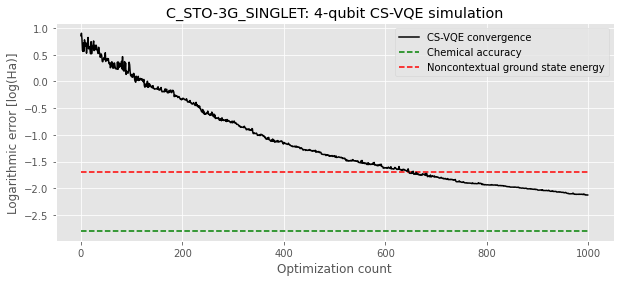

In [23]:
qlm_circ = QLM_circuit(num_sim_q, opt_method='COBYLA', maxiter=1000)
ham_dict, num_sim_q, num_params, instructions = mol_circ.qlm_circuit(uccsd, num_sim_q).values()
result = qlm_circ.run_vqe(ham_dict, instructions)
error  = result.value-mol_circ.truegs; print(error)
fig = plot_qlm_result(result)

In [ ]:
print('Noncon error:', mol_circ.noncon-mol_circ.truegs, '\n')
qlm_circ = QLM_circuit(num_sim_q, opt_method='COBYLA', maxiter=5000)
chemacc=0.0016
current_error=1
final_ops = []
while current_error > chemacc:
    pauli_errors = []
    lost = []
    for pauli in uccsd.keys():
        if pauli not in final_ops:
            anz_ops = final_ops + [pauli] #random.choices(list(uccsd.keys()), k=30)
            #print('Ansatz operators:', anz_ops)
            anz = {op:uccsd[op] for op in anz_ops}
            ham_dict, num_sim_q, num_params, instructions = mol_circ.qlm_circuit(anz, num_sim_q).values()
            try:
                result = qlm_circ.run_vqe(ham_dict, instructions)
                error  = result.value-mol_circ.truegs
                pauli_errors.append((pauli, error))
                #print("Minimum energy =", result.value, '| error =', error, '| Chemical accuracy?', error<0.0016)
                #print("Optimal angles =", result.meta_data["parameters"], '\n')

                if error<0.0016:
                    #final_ops.append(pauli)
                    plot_qlm_result(result)
                    break
            except:
                print('<!> QLM error \n')
                lost.append(pauli)

    pauli_out, current_error = sorted(pauli_errors, key=lambda x:x[1])[0]
    final_ops.append(pauli_out)
    
    print('Ansatz terms:', final_ops, '| error =', current_error, '\n')
    if lost!=[]:
        print('QLM error on terms:', lost)
    
print(final_ops)

Noncon error: 0.07075434472042019 

<!> QLM error 

<!> QLM error 

<!> QLM error 

<!> QLM error 

<!> QLM error 

<!> QLM error 

<!> QLM error 

<!> QLM error 

<!> QLM error 

<!> QLM error 

<!> QLM error 

<!> QLM error 

<!> QLM error 

<!> QLM error 

<!> QLM error 

Ansatz terms: ['IXXIZZYI'] | error = 0.06920550440547402 

QLM error on terms: ['IIZZIIII', 'IIXXIIII', 'IIYYIIII', 'IYXIZZXI', 'IYYZZZXI', 'IYYIZZYI', 'IYXZZZYI', 'YZIXZZZX', 'XZZXZZZX', 'XZIYZZZX', 'YZZYZZZX', 'XZIXZZZY', 'YZZXZZZY', 'YZIYZZZY', 'XZZYZZZY']
Ansatz terms: ['IXXIZZYI', 'YZIXZZZX'] | error = 0.0676568218543494 

Ansatz terms: ['IXXIZZYI', 'YZIXZZZX', 'IXYIZZXI'] | error = 0.06765144588336369 

<!> QLM error 

Ansatz terms: ['IXXIZZYI', 'YZIXZZZX', 'IXYIZZXI', 'IIIIIIII'] | error = 0.06765111981763994 

QLM error on terms: ['ZZZXZZZZ']
Ansatz terms: ['IXXIZZYI', 'YZIXZZZX', 'IXYIZZXI', 'IIIIIIII', 'IYXZZZYI'] | error = 0.06765237690150627 



In [ ]:
#fig.savefig('plots/'+speciesname+'_CS-VQE_test.png', dpi=300, bbox_inches='tight')

In [ ]:
#data={}
#for k in result.meta_data.keys():
#    data[str(k)] = result.meta_data[k]
#    
#with open("data/QLM_circuits/"+speciesname+"_CS-VQE_test.json", "w") as outfile: 
#    json.dump(data, outfile)